In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
df = pd.read_csv('PanglaoDB_markers_27_Mar_2020.tsv', sep='\t')
df.head()

,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
0,Mm Hs,CTRB1,Acinar cells,CTRB,0.017,chymotrypsinogen B1,protein-coding gene,1.0,Endoderm,Pancreas,1.000000,0.957143,0.000629,0.015920
1,Mm Hs,KLK1,Acinar cells,Klk6,0.013,kallikrein 1,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.314286,0.005031,0.012826
2,Mm Hs,RBPJL,Acinar cells,RBP-L|SUHL|RBPSUHL,0.001,recombination signal binding protein for immun...,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.000000,0.000000,0.000000
3,Mm Hs,PTF1A,Acinar cells,PTF1-p48|bHLHa29,0.001,pancreas associated transcription factor 1a,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.157143,0.000629,0.000773
4,Mm,TRY4,Acinar cells,NaN,0.007,trypsin 4,protein coding gene,1.0,Endoderm,Pancreas,NaN,NaN,NaN,NaN


In [4]:
df.shape

(8286, 14)

In [5]:
interested_types = [
    "Platelets",
    "Erythroblasts",
    "Erythroid-like and erythroid precursor cells",
    'Hematopoietic stem cells',
    "B cells",
    "B cells memory",
    "B cells naive",
    "Basophils",
    "Dendritic cells",
    "Eosinophils",
    "Gamma delta T cells",
    "Macrophages",
    "Mast cells",
    "Megakaryocytes",
    "Monocytes",
    "Myeloid-derived suppressor cells",
    "Natural killer T cells",
    "Neutrophils",
    "NK cells",
    "Nuocytes",
    "Plasma cells",
    "Plasmacytoid dendritic cells",
    "Red pulp macrophages",
    "T cells",
    "T cells naive",
    "T cytotoxic cells",
    "T follicular helper cells",
    "T helper cells",
    "T memory cells",
    "T regulatory cells"
]

len(interested_types)

30

In [6]:
# Filter the dataframe for rows where the 'species' column includes 'Hs' and
# the 'cell type' column is in the list of interested_types
marker_genes = df[df['species'].str.contains('Hs') & df['cell type'].isin(interested_types)]
marker_genes.shape

(1859, 14)

In [7]:
len(marker_genes['cell type'].unique())

30

In [8]:
marker_genes['cell type'].value_counts()

Mast cells                                      142
Platelets                                       130
Macrophages                                     128
Dendritic cells                                 121
Monocytes                                        99
B cells                                          98
T cells                                          95
Hematopoietic stem cells                         88
Plasma cells                                     86
NK cells                                         80
Basophils                                        73
Erythroid-like and erythroid precursor cells     70
Neutrophils                                      69
B cells naive                                    69
B cells memory                                   66
Gamma delta T cells                              66
T helper cells                                   60
T memory cells                                   55
Plasmacytoid dendritic cells                     55
Megakaryocyt

## Read PreLect features

In [9]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Zheng/Leiden_HVG_PreLect/feature_selection')

leiden_clusters = [f'Leiden_{i}' for i in range(16)]
features_dict = {}
# Read features for each celltype
for celltype in leiden_clusters:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [10]:
features_dict['Leiden_0']

,Gene,Weight,Tendency
0,ENSG00000142669,0.046448,1
1,ENSG00000169442,0.279994,1
2,ENSG00000122406,0.041489,1
3,ENSG00000197747,0.116894,1
4,ENSG00000196154,1.376208,1
...,...,...,...
92,ENSG00000198888,-0.057154,0
93,ENSG00000198804,-0.265438,0
94,ENSG00000198712,-0.183598,0
95,ENSG00000198938,-0.117060,0


## Convert Ensembl to Gene symbol

In [11]:
import scanpy as sc

adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_68k_Zheng/Zheng_PBMC.h5ad')
adata.shape

(68579, 32738)

In [12]:
adata.var.head()

,gene_symbols
ENSG00000243485,MIR1302-10
ENSG00000237613,FAM138A
ENSG00000186092,OR4F5
ENSG00000238009,RP11-34P13.7
ENSG00000239945,RP11-34P13.8


In [13]:
conversion_df = pd.DataFrame({'Ensembl': adata.var_names.tolist(), 
                              'Gene_symbol': adata.var['gene_symbols'].tolist()})
conversion_df.head()

,Ensembl,Gene_symbol
0,ENSG00000243485,MIR1302-10
1,ENSG00000237613,FAM138A
2,ENSG00000186092,OR4F5
3,ENSG00000238009,RP11-34P13.7
4,ENSG00000239945,RP11-34P13.8


In [14]:
conversion_df.shape

(32738, 2)

In [15]:
def convert_gene_names(feature_df, ensemble_to_symbol_df):
    converted = feature_df.copy()
    converted['Symbol'] = converted['Gene'].map(ensemble_to_symbol_df.set_index('Ensembl')['Gene_symbol'])
    return converted

In [16]:
new_features_dict = {}

for cls in leiden_clusters:
    new_features_dict[cls] = convert_gene_names(features_dict[cls], conversion_df)
    print(cls, new_features_dict[cls].shape)

Leiden_0 (97, 4)
Leiden_1 (21, 4)
Leiden_2 (141, 4)
Leiden_3 (89, 4)
Leiden_4 (152, 4)
Leiden_5 (17, 4)
Leiden_6 (22, 4)
Leiden_7 (12, 4)
Leiden_8 (7, 4)
Leiden_9 (7, 4)
Leiden_10 (4, 4)
Leiden_11 (5, 4)
Leiden_12 (2, 4)
Leiden_13 (2, 4)
Leiden_14 (7, 4)
Leiden_15 (5, 4)


In [17]:
new_features_dict['Leiden_0'].head()

,Gene,Weight,Tendency,Symbol
0,ENSG00000142669,0.046448,1,SH3BGRL3
1,ENSG00000169442,0.279994,1,CD52
2,ENSG00000122406,0.041489,1,RPL5
3,ENSG00000197747,0.116894,1,S100A10
4,ENSG00000196154,1.376208,1,S100A4


In [18]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Zheng/Leiden_HVG_PreLect/feature_selection


In [20]:
# export all df in new_features_dict to txt
for key, value in new_features_dict.items():
    print(key)
    # print(type(value))
    value.to_csv(f'{key}_features_symbol.txt', sep='\t', index=False)

Leiden_0
Leiden_1
Leiden_2
Leiden_3
Leiden_4
Leiden_5
Leiden_6
Leiden_7
Leiden_8
Leiden_9
Leiden_10
Leiden_11
Leiden_12
Leiden_13
Leiden_14
Leiden_15


## Check if gene names in adata is compatible with gene names in DB

In [21]:
all_symbol = []
for cls in leiden_clusters:
    all_symbol.extend(new_features_dict[cls]['Symbol'].tolist())
len(all_symbol)

590

In [22]:
# adata 裡面gene 和 DB裡面gene的交集
print('all_genes_unique:', len(set(all_symbol)))
db_all_genes = marker_genes['official gene symbol'].tolist()
db_all_genes_unique = list(set(db_all_genes))
print('db_all_genes_unique:', len(db_all_genes_unique))
common_genes = list(set(all_symbol) & set(db_all_genes))
print('common_genes:', len(common_genes))



all_genes_unique: 222
db_all_genes_unique: 1188
common_genes: 49


In [23]:
missing = list(set(all_symbol) - set(common_genes))  # 590-49
len(missing)

173

## Compare PreLect features in every Leiden cluster to marker gene DB

### Find common between (unique PreLect feature) and (marker genes)
Then subset the marker_genes dataframe with these common genes  
There may be duplicate genes in marker_genes that corresponds to different cell types

In [24]:
new_features_dict['Leiden_0'].head()

,Gene,Weight,Tendency,Symbol
0,ENSG00000142669,0.046448,1,SH3BGRL3
1,ENSG00000169442,0.279994,1,CD52
2,ENSG00000122406,0.041489,1,RPL5
3,ENSG00000197747,0.116894,1,S100A10
4,ENSG00000196154,1.376208,1,S100A4


In [25]:
marker_genes.head()

,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
421,Mm Hs,CD2,B cells,NaN,0.040,CD2 molecule,protein-coding gene,NaN,Mesoderm,Immune system,0.000000,0.213178,0.095847,0.026554
422,Mm Hs,CD5,B cells,NaN,0.004,CD5 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.000000,0.000000,0.004153,0.004502
423,Mm Hs,MS4A1,B cells,Bp35|MS4A2|CD20,0.014,membrane spanning 4-domains A1,protein-coding gene,1.0,Mesoderm,Immune system,0.483871,0.620155,0.011182,0.001566
424,Mm Hs,CR2,B cells,CD21|C3DR,0.001,complement C3d receptor 2,protein-coding gene,1.0,Mesoderm,Immune system,0.048387,0.034884,0.000000,0.000000
425,Mm Hs,CD22,B cells,SIGLEC-2|SIGLEC2,0.003,CD22 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.096774,0.127907,0.001278,0.000196


In [26]:
set1 = set(new_features_dict['Leiden_0']['Symbol'].tolist())
set2 = set(marker_genes['official gene symbol'].tolist())

common = list(set1 & set2)

In [27]:
len(common)

18

In [28]:
cdf = marker_genes[marker_genes['official gene symbol'].isin(common)]
cdf.shape

(52, 14)

In [36]:
len(set(cdf['official gene symbol'].tolist()))

18

### Function for finding common genes

In [30]:
def find_common_genes_in_leiden(features_df, marker_df):
    set1 = set(features_df['Symbol'].tolist())
    set2 = set(marker_df['official gene symbol'].tolist())
    common = list(set1 & set2)
    marker_df_common = marker_df[marker_df['official gene symbol'].isin(common)]

    return common, marker_df_common

In [90]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Zheng/Leiden_HVG_PreLect/Compare_w_marker_gene_db')

for clus in leiden_clusters:
    print(clus)
    common_genes, common_df = find_common_genes_in_leiden(new_features_dict[clus], marker_genes)
    print(len(common_genes), common_df.shape)
    common_df.to_csv(f'{clus}_common_w_DB.csv', sep='\t', index=False)

Leiden_0
18 (52, 14)
Leiden_1
11 (33, 14)
Leiden_2
23 (69, 14)
Leiden_3
16 (47, 14)
Leiden_4
27 (88, 14)
Leiden_5
7 (27, 14)
Leiden_6
8 (26, 14)
Leiden_7
5 (15, 14)
Leiden_8
4 (22, 14)
Leiden_9
2 (4, 14)
Leiden_10
0 (0, 14)
Leiden_11
1 (1, 14)
Leiden_12
0 (0, 14)
Leiden_13
0 (0, 14)
Leiden_14
0 (0, 14)
Leiden_15
0 (0, 14)


## Print unmatched PreLect features

In [37]:
features_dict['Leiden_0'].head()

,Gene,Weight,Tendency
0,ENSG00000142669,0.046448,1
1,ENSG00000169442,0.279994,1
2,ENSG00000122406,0.041489,1
3,ENSG00000197747,0.116894,1
4,ENSG00000196154,1.376208,1


In [38]:
new_features_dict['Leiden_0'].head()

,Gene,Weight,Tendency,Symbol
0,ENSG00000142669,0.046448,1,SH3BGRL3
1,ENSG00000169442,0.279994,1,CD52
2,ENSG00000122406,0.041489,1,RPL5
3,ENSG00000197747,0.116894,1,S100A10
4,ENSG00000196154,1.376208,1,S100A4


In [39]:
false_positives_dict = {}
for clus in leiden_clusters:
    print(clus)
    all_PreLect = new_features_dict[clus]['Symbol'].tolist()
    all_DB = marker_genes['official gene symbol'].tolist()

    ### False positives
    # the genes that are in PreLect but not in the DB
    false_positives = list(set(all_PreLect) - set(all_DB))
    print('False positives:', len(false_positives))

    false_positives_dict[clus] = false_positives
    

Leiden_0
False positives: 79
Leiden_1
False positives: 10
Leiden_2
False positives: 118
Leiden_3
False positives: 73
Leiden_4
False positives: 125
Leiden_5
False positives: 10
Leiden_6
False positives: 14
Leiden_7
False positives: 7
Leiden_8
False positives: 3
Leiden_9
False positives: 5
Leiden_10
False positives: 4
Leiden_11
False positives: 4
Leiden_12
False positives: 2
Leiden_13
False positives: 2
Leiden_14
False positives: 7
Leiden_15
False positives: 5


In [40]:
false_positives_dict['Leiden_1']

['FOS',
 'OAZ1',
 'MALAT1',
 'TMSB10',
 'RPLP0',
 'FTH1',
 'JUN',
 'TMSB4X',
 'B2M',
 'EEF1A1']

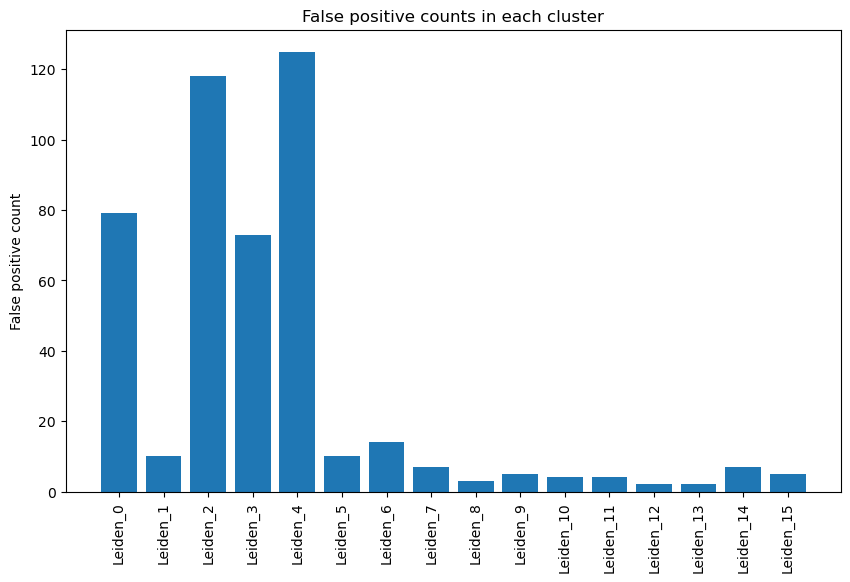

In [42]:
# plot false positive counts in each cluster
plt.figure(figsize=(10, 6))
plt.bar(false_positives_dict.keys(), [len(fp) for fp in false_positives_dict.values()])
plt.xticks(rotation=90)
plt.ylabel('False positive count')
plt.title('False positive counts in each cluster')
plt.show()